# **Imports**

In [1]:
import collections
import nltk
import pandas as pd 
import numpy as np

# **Reading Data from JSON**

In [2]:
dataFile = 'News_Category_Dataset.csv'
dataDf = pd.read_csv(dataFile)

In [3]:
dataDf.head()

,Unnamed: 0,news,category
0,0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


# **Processing Text**

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
newsTexts = dataDf["news"].tolist()
newsLabels = dataDf["category"].tolist()

In [6]:
tokenObj = Tokenizer()
tokenObj.fit_on_texts(newsTexts)
sequences = tokenObj.texts_to_sequences(newsTexts)

In [7]:
word_index = tokenObj.word_index
print("Number of Unique Words are: ", len(word_index))

Number of Unique Words are:  114404


In [8]:
maxLengthOfTexts = int(sum(map(len, sequences))/len(sequences))
maxLengthOfTexts

29

In [9]:
paddedSequences = pad_sequences(sequences, maxlen=maxLengthOfTexts)
paddedSequences

array([[    0,     0,    74, ...,    62,     6,   220],
       [    0,     0,     0, ...,    37,     3,   966],
       [    0,     0,     0, ...,     3,  1085,  2036],
       ...,
       [14677,     4,    39, ...,   435,    61,    39],
       [    0, 31324,  1568, ...,   856,     6, 18773],
       [ 4625,  3562, 10725, ...,  3969,     2,  1281]])

# **Generating Vectors for Feature Words using GloVe**

In [10]:
def getGloveEmbedding():
    file = "glove.6B.100d.txt"
    gloveEmbeddingToVec = collections.defaultdict(list)
    with open(file, encoding="utf8") as fileObj:
      for line in fileObj:
        line = line.strip("\n")
        splitted = line.split(" ")
        gloveEmbeddingToVec[splitted[0]] = [np.float64(i) for i in splitted[1:]]
    return gloveEmbeddingToVec

In [11]:
gloveEmbeddingToVec = getGloveEmbedding()
print("Total Glove Embeddings: ", len(gloveEmbeddingToVec))

Total Glove Embeddings:  120688


# **One Hot Encoding of Categorical Labels**

In [12]:
import sklearn

In [13]:
categories = dataDf["category"].unique().tolist()
categoryDict = {}
count = 0
for category in sorted(categories):
  categoryDict[category] = [1 if x==category else 0 for x in categories]
  count += 1

In [14]:
newsLabels = [np.array(categoryDict[x]) for x in dataDf["category"].tolist()]
len(sequences),len(newsLabels)

(191973, 191973)

In [15]:
EMBEDDING_DIM=100
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = gloveEmbeddingToVec.get(word)
    if embedding_vector:
        embedding_matrix[i] = embedding_vector

# **Train and Test Data Split**

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(np.array([i for i in paddedSequences]), np.array([i for i in newsLabels]), train_size=0.8)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# **Building Neural Networks**

In [17]:
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Concatenate
from keras.models import Model
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [18]:
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxLengthOfTexts,
                            trainable=False)

# **CNN model**

In [20]:
def getCNN():
  inp = Input(shape=(maxLengthOfTexts,), dtype='int32')
  embedding = embedding_layer(inp)

  conv = Conv1D(256, kernel_size=2, padding='same', activation='relu', strides=1)(embedding)
  pool = MaxPooling1D(pool_size=3)(conv)
  drop1 = Dropout(0.5)(pool)
  
  conv = Conv1D(256, kernel_size=3, padding='same', activation='relu', strides=1)(embedding)
  pool = MaxPooling1D(pool_size=3)(conv)
  drop2 = Dropout(0.5)(pool)

  conv = Conv1D(256, kernel_size=4, padding='same', activation='relu', strides=1)(embedding)
  pool = MaxPooling1D(pool_size=3)(conv)
  drop3 = Dropout(0.5)(pool)

  merged = Concatenate()([drop1, drop2, drop3])
  flatten = Flatten()(merged)
  drop = Dropout(0.5)(flatten)
  outp = Dense(len(categories), activation='softmax')(drop)

  cnnModel = Model(inputs=inp, outputs=outp)
  cnnModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return cnnModel

In [21]:
cnnModel = getCNN()
print(cnnModel.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 29, 100)      11440500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29, 256)      51456       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [22]:
fittedModel_cnn = cnnModel.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=True, callbacks=[earlyStopping])

Instructions for updating:
Use tf.cast instead.
Train on 122862 samples, validate on 30716 samples
Epoch 1/50
122862/122862 [==============================] - 9s 76us/step - loss: 1.6705 - acc: 0.5112 - val_loss: 1.3585 - val_acc: 0.6070
Epoch 2/50
122862/122862 [==============================] - 7s 60us/step - loss: 1.4265 - acc: 0.5840 - val_loss: 1.3090 - val_acc: 0.6159
Epoch 3/50
122862/122862 [==============================] - 7s 59us/step - loss: 1.3749 - acc: 0.5999 - val_loss: 1.2753 - val_acc: 0.6316
Epoch 4/50
122862/122862 [==============================] - 7s 59us/step - loss: 1.3434 - acc: 0.6085 - val_loss: 1.2612 - val_acc: 0.6347
Epoch 5/50
122862/122862 [==============================] - 7s 59us/step - loss: 1.3219 - acc: 0.6145 - val_loss: 1.2551 - val_acc: 0.6365
Epoch 6/50
122862/122862 [==============================] - 7s 60us/step - loss: 1.2993 - acc: 0.6200 - val_loss: 1.2483 - val_acc: 0.6397
Epoch 7/50
122862/122862 [==============================] - 7s 60us

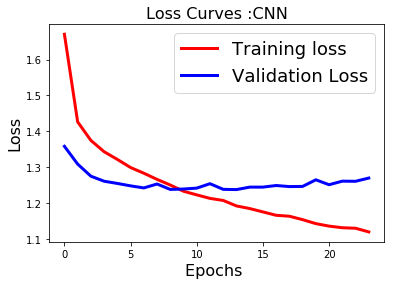

In [23]:
fig1 = plt.figure()
plt.plot(fittedModel_cnn.history['loss'],'r',linewidth=3.0)
plt.plot(fittedModel_cnn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

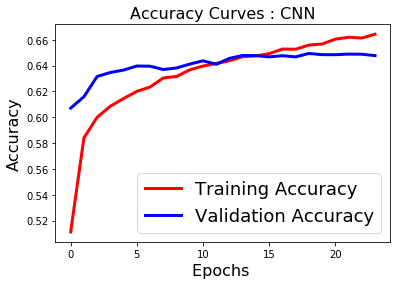

In [24]:
fig2=plt.figure()
plt.plot(fittedModel_cnn.history['acc'],'r',linewidth=3.0)
plt.plot(fittedModel_cnn.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [25]:
y_pred_cnn = cnnModel.predict(X_test, batch_size=None, verbose=True)

38395/38395 [==============================] - 2s 51us/step


In [26]:
temp = np.zeros((len(y_pred_cnn), len(y_pred_cnn[0])))
count = 0
for y in y_pred_cnn:
  idx = np.argmax(y)
  temp[count][idx] = 1
  count += 1

In [27]:
accCount_cnn = 0
for i in range(0, len(y_test)):
  if np.array_equal(temp[i], y_test[i]):
      accCount_cnn += 1

In [28]:
cnnAccuracy = round(accCount_cnn/len(y_pred_cnn) * 100, 2)
print("Test Accuracy is: ", cnnAccuracy)

Test Accuracy is:  64.75


## **Saving the CNN Model**

In [29]:
model_json = cnnModel.to_json()
with open("cnnModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnnModel.save_weights("cnnModel.h5")
print("Saved model to disk")

Saved model to disk


# **RNN Model**

In [30]:
from keras.models import Sequential
from keras.layers import SpatialDropout1D, LSTM, Dense

In [31]:
def getRnnModel():
  model = Sequential()
  model.add(embedding_layer)
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(len(categories), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


In [32]:
rnnModel = getRnnModel()

In [33]:
rnnModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 100)           11440500  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 29, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
Total params: 11,685,320
Trainable params: 244,820
Non-trainable params: 11,440,500
_________________________________________________________________


In [34]:
fittedModel_rnn = rnnModel.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=True, callbacks=[earlyStopping])

Train on 122862 samples, validate on 30716 samples
Epoch 1/50
122862/122862 [==============================] - 62s 505us/step - loss: 1.8683 - acc: 0.4410 - val_loss: 1.3715 - val_acc: 0.5851
Epoch 2/50
122862/122862 [==============================] - 59s 482us/step - loss: 1.5027 - acc: 0.5481 - val_loss: 1.2690 - val_acc: 0.6125
Epoch 3/50
122862/122862 [==============================] - 59s 478us/step - loss: 1.4187 - acc: 0.5728 - val_loss: 1.2329 - val_acc: 0.6248
Epoch 4/50
122862/122862 [==============================] - 60s 487us/step - loss: 1.3733 - acc: 0.5850 - val_loss: 1.1940 - val_acc: 0.6382
Epoch 5/50
122862/122862 [==============================] - 60s 486us/step - loss: 1.3493 - acc: 0.5932 - val_loss: 1.1811 - val_acc: 0.6392
Epoch 6/50
122862/122862 [==============================] - 58s 475us/step - loss: 1.3237 - acc: 0.5981 - val_loss: 1.1635 - val_acc: 0.6482
Epoch 7/50
122862/122862 [==============================] - 59s 479us/step - loss: 1.3075 - acc: 0.6041

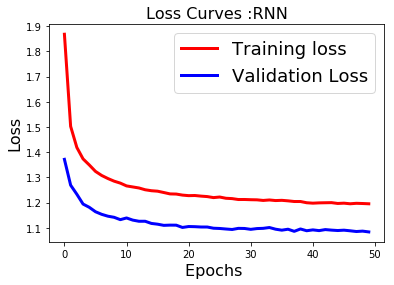

In [35]:
fig1 = plt.figure()
plt.plot(fittedModel_rnn.history['loss'],'r',linewidth=3.0)
plt.plot(fittedModel_rnn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

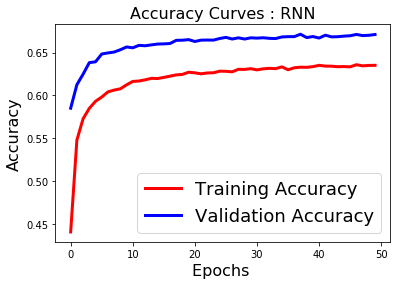

In [36]:
fig2=plt.figure()
plt.plot(fittedModel_rnn.history['acc'],'r',linewidth=3.0)
plt.plot(fittedModel_rnn.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [37]:
y_pred_rnn = rnnModel.predict(X_test, batch_size=None, verbose=True)

38395/38395 [==============================] - 26s 665us/step


In [38]:
temp = np.zeros((len(y_pred_rnn), len(y_pred_rnn[0])))
count = 0
for y in y_pred_rnn:
  idx =np.argmax(y)
  temp[count][idx] = 1
  count+=1

In [39]:
accCount_rnn = 0
for i in range(0, len(y_test)):
  if np.array_equal(temp[i], y_test[i]):
      accCount_rnn += 1

In [40]:
rnnAccuracy = round(accCount_rnn/len(y_pred_rnn) * 100, 2)
print("Test Accuracy is: ", rnnAccuracy)

Test Accuracy is:  67.01


## Saving the RNN Model

In [41]:
model_json = rnnModel.to_json()
with open("rnnModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
rnnModel.save_weights("rnnModel.h5")
print("Saved model to disk")

Saved model to disk


# **HAN Model**

In [42]:
from keras.callbacks import Callback
from keras.layers import Bidirectional, TimeDistributed, Layer, LSTM
from keras import initializers, regularizers, constraints
import keras.backend as K
import re
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence
from nltk import punkt
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ckaidab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Preprocessing for HAN

In [43]:
MAX_SENTS = 3
newsSent = []
newsList = []
for line in newsTexts:
    line = re.sub(r"\\", "", line)
    line = re.sub(r"\'", "", line)
    line = re.sub(r"\"", "", line)
    line = re.sub(r"\‘", "", line)
    line = line.strip().lower()
    newsList.append(line)
    sentences = tokenize.sent_tokenize(line)
    newsSent.append(sentences)

In [44]:
data = np.zeros((len(newsList), MAX_SENTS, maxLengthOfTexts), dtype='int32')
MAX_NB_WORDS = len(tokenObj.word_index)+1

for i, sentences in enumerate(newsSent):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if(k<maxLengthOfTexts and tokenObj.word_index.get(word,MAX_NB_WORDS+1)<MAX_NB_WORDS):
                    data[i,j,k] = tokenObj.word_index[word]
                    k=k+1  

### Train test and validation split for HAN

In [45]:
X_train_han, X_test_han, y_train_han, y_test_han = sklearn.model_selection.train_test_split(data, np.array([i for i in newsLabels]), test_size=0.33, random_state=42)

### Build HAN model

In [46]:
class AttentionWithContext(Layer):

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [47]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [48]:
def getHAN():
    sentence_input = Input(shape=(maxLengthOfTexts,), dtype='int32')
    word_input = Input(shape=(maxLengthOfTexts,), dtype='float32')
    word_sequences = embedding_layer(word_input)
    word_lstm = Bidirectional(LSTM(150, dropout=0.4, recurrent_dropout=0.5, return_sequences=True))(word_sequences)
    word_dense = TimeDistributed(Dense(200))(word_lstm)
    word_att = AttentionWithContext()(word_dense)
    wordEncoder = Model(word_input, word_att)

    sent_input = Input(shape=(MAX_SENTS,maxLengthOfTexts), dtype='float32')
    sent_encoder = TimeDistributed(wordEncoder)(sent_input)
    sent_lstm = Bidirectional(LSTM(150, dropout=0.4, recurrent_dropout=0.5, return_sequences=True))(sent_encoder)
    sent_dense = TimeDistributed(Dense(200))(sent_lstm)
    sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
    preds = Dense(len(categories), activation='softmax')(sent_att)
    model = Model(sent_input, preds)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

    print("Hierachical LSTM")
    return model

In [49]:
hanModel = getHAN()

Hierachical LSTM


In [50]:
hanModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 29)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 200)            11842300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 300)            421200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 200)            60200     
_________________________________________________________________
attention_with_context_2 (At (None, 200)               40400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                4020      
Total para

In [51]:
fittedModel_han = hanModel.fit(X_train_han, y_train_han, validation_split=0.2, epochs=50, batch_size=128, verbose=True, callbacks=[earlyStopping])

Train on 102896 samples, validate on 25725 samples
Epoch 1/50
102896/102896 [==============================] - 102s 994us/step - loss: 1.5945 - acc: 0.5355 - val_loss: 1.1821 - val_acc: 0.6515
Epoch 2/50
102896/102896 [==============================] - 97s 939us/step - loss: 1.2497 - acc: 0.6347 - val_loss: 1.0804 - val_acc: 0.6763
Epoch 3/50
102896/102896 [==============================] - 97s 944us/step - loss: 1.1568 - acc: 0.6591 - val_loss: 1.0186 - val_acc: 0.6932
Epoch 4/50
102896/102896 [==============================] - 97s 946us/step - loss: 1.0945 - acc: 0.6743 - val_loss: 0.9995 - val_acc: 0.6990
Epoch 5/50
102896/102896 [==============================] - 97s 944us/step - loss: 1.0531 - acc: 0.6853 - val_loss: 0.9681 - val_acc: 0.7089
Epoch 6/50
102896/102896 [==============================] - 97s 943us/step - loss: 1.0214 - acc: 0.6944 - val_loss: 0.9545 - val_acc: 0.7134
Epoch 7/50
102896/102896 [==============================] - 97s 947us/step - loss: 0.9896 - acc: 0.702

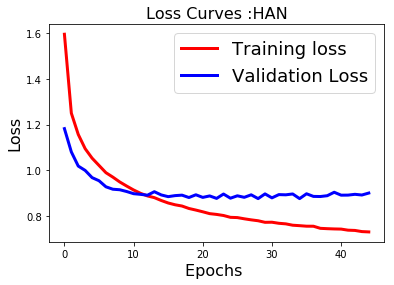

In [52]:
fig1 = plt.figure()
plt.plot(fittedModel_han.history['loss'],'r',linewidth=3.0)
plt.plot(fittedModel_han.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

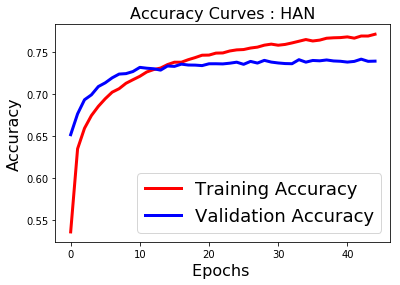

In [53]:
fig2=plt.figure()
plt.plot(fittedModel_han.history['acc'],'r',linewidth=3.0)
plt.plot(fittedModel_han.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

In [54]:
y_pred_han = hanModel.predict(X_test_han, batch_size=None, verbose=True)

63352/63352 [==============================] - 68s 1ms/step


In [55]:
temp = np.zeros((len(y_pred_han), len(y_pred_han[0])))
count = 0
for y in y_pred_han:
  idx =np.argmax(y)
  temp[count][idx] = 1
  count+=1

In [56]:
accCount_han = 0
for i in range(0, len(y_test_han)):
  if np.array_equal(temp[i], y_test_han[i]):
      accCount_han += 1


In [57]:
hanAccuracy = round(accCount_han/len(y_pred_han) * 100, 2)
print("Test Accuracy is: ", hanAccuracy)

Test Accuracy is:  74.05


## Saving HAN Model

In [58]:
model_json = hanModel.to_json()
with open("hanModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
hanModel.save_weights("hanModel.h5")
print("Saved model to disk")

Saved model to disk


# Visualizing the Results

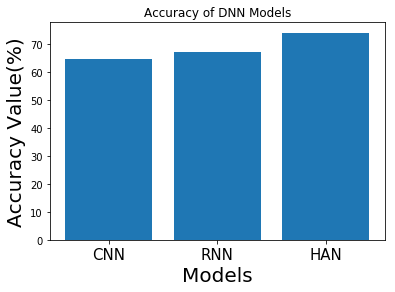

In [59]:
import matplotlib.pyplot as plt
import numpy as np
label = [ 'CNN', 'RNN', 'HAN' ]
accuracies = [ cnnAccuracy, rnnAccuracy, hanAccuracy ]
index = np.arange(len(label))
plt.bar(label, accuracies)
plt.xlabel('Models', fontsize=20)
plt.ylabel('Accuracy Value(%)', fontsize=20)
plt.xticks(index, label, fontsize=15)
plt.title('Accuracy of DNN Models')
plt.show()

# Running CNN Model by loading saved weights

In [60]:
from keras.models import model_from_json

In [61]:
json_file = open('cnnModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_cnn_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_cnn_model.load_weights("cnnModel.h5")
print("Loaded model from disk")

Loaded model from disk


In [62]:
loadedCnnModel_pred = loaded_cnn_model.predict(X_test, batch_size=None, verbose=True)

38395/38395 [==============================] - 2s 65us/step


In [63]:
temp = np.zeros((len(loadedCnnModel_pred), len(loadedCnnModel_pred[0])))
count = 0
for y in loadedCnnModel_pred:
  idx = np.argmax(y)
  temp[count][idx] = 1
  count += 1

In [64]:
accCount_cnn = 0
for i in range(0, len(y_test)):
  if np.array_equal(temp[i], y_test[i]):
      accCount_cnn += 1


In [65]:
cnnAccuracy = round(accCount_cnn/len(loadedCnnModel_pred) * 100, 2)
print("Test Accuracy is: ", cnnAccuracy)

Test Accuracy is:  64.75


# Running RNN Model by loading saved weights

In [66]:
from keras.models import model_from_json

In [67]:
json_file = open('rnnModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_rnn_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_rnn_model.load_weights("rnnModel.h5")
print("Loaded model from disk")

Loaded model from disk


In [68]:
loadedRnnModel_pred = loaded_rnn_model.predict(X_test, batch_size=None, verbose=True)

38395/38395 [==============================] - 25s 663us/step


In [69]:
temp = np.zeros((len(loadedRnnModel_pred), len(loadedRnnModel_pred[0])))
count = 0
for y in loadedRnnModel_pred:
  idx = np.argmax(y)
  temp[count][idx] = 1
  count += 1

In [70]:
accCount_rnn = 0
for i in range(0, len(y_test)):
  if np.array_equal(temp[i], y_test[i]):
      accCount_rnn += 1

In [71]:
rnnAccuracy = round(accCount_rnn/len(y_pred_rnn) * 100, 2)
print("Test Accuracy is: ", rnnAccuracy)

Test Accuracy is:  67.01


# Running HAN Model by loading saved weights

In [72]:
from keras.models import model_from_json

In [73]:
json_file = open('hanModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_han_model = getHAN()
# load weights into new model
loaded_han_model.load_weights("hanModel.h5")
print("Loaded model from disk")

Hierachical LSTM
Loaded model from disk


In [74]:
loadedHanModel_pred = loaded_han_model.predict(X_test_han, batch_size=None, verbose=True)

63352/63352 [==============================] - 68s 1ms/step


In [75]:
temp = np.zeros((len(loadedHanModel_pred), len(loadedHanModel_pred[0])))
count = 0
for y in loadedHanModel_pred:
  idx = np.argmax(y)
  temp[count][idx] = 1
  count += 1

In [76]:
accCount_han = 0
for i in range(0, len(y_test_han)):
  if np.array_equal(temp[i], y_test_han[i]):
      accCount_han += 1

In [77]:
hanAccuracy = round(accCount_han/len(y_pred_han) * 100, 2)
print("Test Accuracy is: ", hanAccuracy)

Test Accuracy is:  74.05
